In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib
from glob import glob
import pickle

import numpy as np
import matplotlib.pyplot as plt

from utilities import reduced_parameter as red
from field.utils import profiling_rad

import utilities.reduced_parameter as red

from utilities.etc import categorizing_result
from analyze_tools import plot_tools as pt
import analyze_tools.monte_carlo as at

import animation as an

def assert_path(path):
    try: 
        assert os.path.isdir(path)
    except AssertionError:
        raise Exception("Path {} is not exist".format(path))

linestyle_list = ["solid", "dashed", "dotted","dashdot"]
scatter_list = ["o", "^","v"]

In [47]:
5.894 * 6e23 * 1e-3 / (red.mass_dict['Xe'] * red.M_)

2.693517552344756e+19

In [42]:
( 3e19 * (red.sigma)**3 * (1e2)**3 ) / 2

594.777315

In [2]:
pt = importlib.reload(pt)
red = importlib.reload(red)

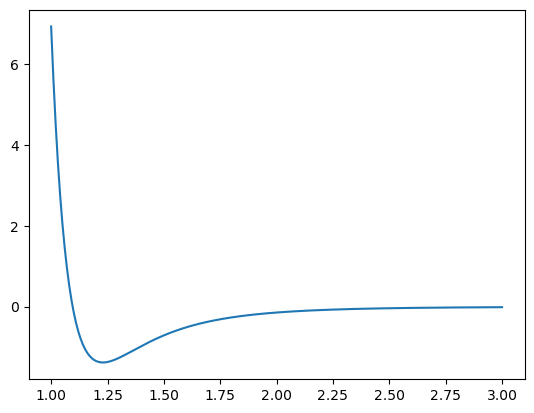

In [3]:
potential_func = lambda r: 4 * red.epsilon_Ar_Xe * ((red.sigma_Ar_Xe**12 / r**12) - (red.sigma_Ar_Xe**6 / r**6))

r = np.linspace(1,3,400)
fig,ax = plt.subplots()
ax.plot(r, potential_func(r))

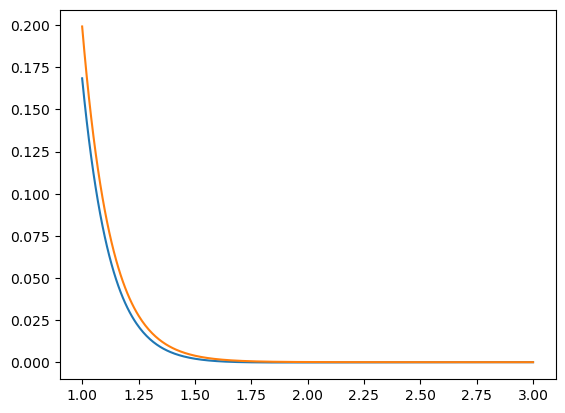

In [4]:
dipole_func = lambda d: red.mu0 * np.exp(-red.a * (d - red.d0)) - red.d7/d**7
dipole_func2 = lambda d: red.mu0 * np.exp(-red.a * (d - red.d0))# - red.d7/d**7

fig,ax = plt.subplots()
ax.plot(r, dipole_func(r))
ax.plot(r, dipole_func2(r))

In [24]:
ROOT2 = "pickle_jar/"

temperature_list = []

nofield_path = ROOT2 + "nofield-292_256_400"
freefield_path = ROOT2 + "free-292_256_1-zero_None_None-c0"
cavityfield_path = ROOT2 + "cavity-292_256_400-zpve_20_30-cTrue"

assert_path(freefield_path)

fig_root = "figure/Final_temp"
if not os.path.isdir(fig_root):
    os.mkdir(fig_root)

In [25]:
nofield_result_dict = categorizing_result(nofield_path,KEYWORDS = "")
freefield_result_dict = categorizing_result(freefield_path, KEYWORDS = '')
cavityfield_result_dict = categorizing_result(cavityfield_path, KEYWORDS = '')

In [26]:
k_list = np.sort(freefield_result_dict[0]['field'].k_val)
#k_list = np.arange(1,200) * (2 * np.pi / 2e7)
wn_list = np.array(k_list * red.c)

In [27]:
def fft(wn_list, time, mu):
    def single_fft(wn, time, mu):
        e = np.exp(1j *  wn * time)
        return np.sum(e * mu, axis = 0)
    
    fft_result = []

    if len(mu.shape)  == 2:
        time = np.tile(time[:,np.newaxis], (1, mu.shape[1]))
    
    #wn_list = np.arange(0.5, 1000, 0.1)
    for wn in wn_list:
        fft_result.append(single_fft(wn = wn, time = time, mu = mu))
    
    fft_result = np.array(fft_result)

    return fft_result

In [22]:
#t = []
#total_dipole = []
autocorr_list = []

for i, result_dict in nofield_result_dict.items():
    
    #if i >= 10 : continue
        
    t = red.convert_time(np.array(
        result_dict['atoms'].observable['t']))
    t -= t[0]
    total_dipole = np.array(
        result_dict['atoms'].observable['dipole_velocity']
    ) #/ 2
    
    autocorr = fft(wn_list, t, total_dipole)
    
    autocorr_list.append( np.einsum('ni,ni->n',autocorr, np.conjugate(autocorr)) )
    #autocorr_list.append( autocorr * np.conjugate(autocorr) )

autocorr = np.mean(autocorr_list, axis = 0)
#autocorr = autocorr_list[0]

spec1 = (2 * np.pi)**4 * autocorr * wn_list**2

In [28]:
autocorr_list = []

for i, result_dict in cavityfield_result_dict.items():
    
    #if i >= 10 : continue
        
    t = red.convert_time(np.array(
        result_dict['atoms'].observable['t']))
    t -= t[0]
    total_dipole = np.array(
        result_dict['atoms'].observable['dipole_velocity']
    ) #/ 2
    
    autocorr = fft(wn_list, t, total_dipole)
    
    autocorr_list.append( np.einsum('ni,ni->n',autocorr, np.conjugate(autocorr)) )
    #autocorr_list.append( autocorr * np.conjugate(autocorr) )

autocorr = np.mean(autocorr_list, axis = 0)
#autocorr = autocorr_list[0]

spec2 = (2 * np.pi)**4 * autocorr * wn_list**2

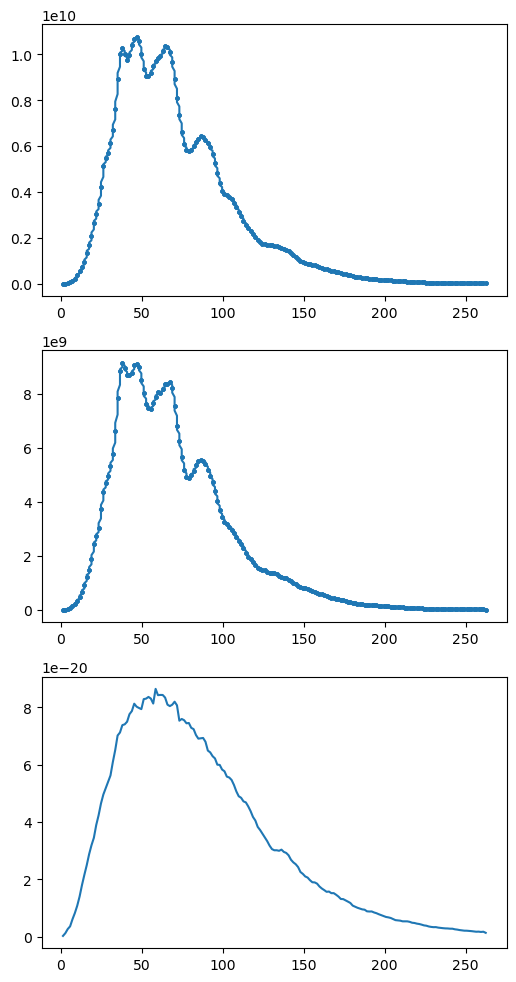

In [33]:
from copy import deepcopy
fig,ax = plt.subplots(3, figsize = (6,12))

wn_real = red.convert_wavenumber(k_list)
ax[0].scatter(wn_real, spec1, s = 5)

w, s = pt.moving_average(wn_real, spec1, w = 4)
ax[0].plot(w, s)

wn_real = red.convert_wavenumber(k_list)
ax[1].scatter(wn_real, spec2, s = 5)

w, s = pt.moving_average(wn_real, spec2, w = 4)
ax[1].plot(w, s)

rad_profile = []

for i, rd in freefield_result_dict.items():
    
    Afield = rd["field"]
    
    rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "cm-1") 
    omega = red.convert_wavenumber(Afield.k_val)
    omega_profile, final_rad_profile = profiling_rad(omega, rad_energy)
    
    foo = np.argsort(omega_profile)
    omega_profile = np.array(omega_profile)[foo]
    final_rad_profile = np.array(final_rad_profile)[foo]
    
    rad_profile.append(final_rad_profile)
    
rad_profile = np.mean(rad_profile, axis = 0)
#rad_profile = rad_profile[1]

#ax[1].scatter(omega_profile, rad_profile, s  = 5)

o, f = pt.moving_average(omega_profile, rad_profile, w = 10)
ax[2].plot(o, f)

fig.savefig("test.jpeg",dpi = 600)

In [93]:
rad_energy

array([2.18384964e-23+0.j, 6.98073801e-22+0.j, 1.68599561e-21+0.j,
       6.20430015e-22+0.j, 2.12977419e-21+0.j, 1.64873995e-21+0.j,
       9.00281191e-21+0.j, 3.65904681e-21+0.j, 6.15586640e-21+0.j,
       3.14351604e-21+0.j, 4.54605875e-21+0.j, 7.82663602e-21+0.j,
       3.33918948e-20+0.j, 5.55392763e-21+0.j, 5.49844501e-21+0.j,
       1.02015094e-20+0.j, 2.17186061e-21+0.j, 1.92681604e-20+0.j,
       2.27117581e-20+0.j, 2.58970254e-20+0.j, 1.68246654e-20+0.j,
       1.09082856e-20+0.j, 3.46703739e-20+0.j, 6.44708985e-21+0.j,
       3.26866659e-20+0.j, 5.33789021e-20+0.j, 2.89254735e-20+0.j,
       1.37508116e-20+0.j, 1.43496820e-20+0.j, 2.15323867e-20+0.j,
       7.74825696e-21+0.j, 9.40608204e-21+0.j, 2.68874766e-20+0.j,
       2.07810425e-20+0.j, 5.48910196e-20+0.j, 4.02048493e-20+0.j,
       1.84107247e-20+0.j, 1.93011331e-21+0.j, 8.54849556e-20+0.j,
       1.48045801e-20+0.j, 1.97820271e-20+0.j, 4.27056345e-20+0.j,
       1.84101519e-20+0.j, 3.27904419e-20+0.j, 1.40313648e-20+

In [ ]:
atoms = result_dict['atoms']

512 / (atoms.Lxy * atoms.Lxy * atoms.Lz * red.sigma ** 3)

In [ ]:
44.615 * 6e23 / (1e2) ** 3 # atoms / cm^3

NameError: name 'free_result_dict' is not defined

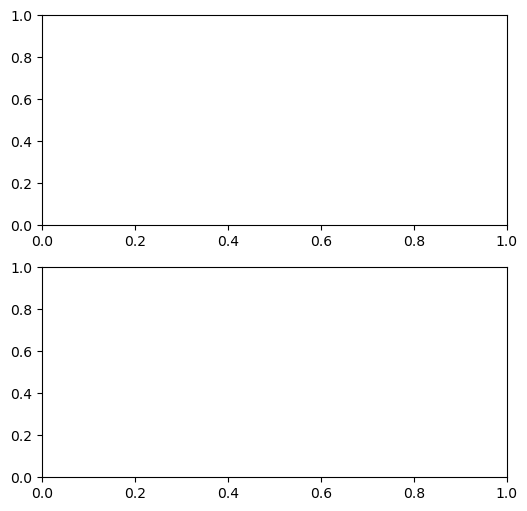

In [31]:
dipole_plot = pt.Plot(n_dipole_plots = 2)

for i, result in free_result_dict.items():
    atoms = result['atoms']
    dipole_plot.add_dipole_plot(
        0, 
        red.convert_time(atoms.observable["t"]), 
        red.convert_dipole(atoms.observable["total_dipole"]),
        index = i
    )

for i, result in cave_result_dict.items():
    atoms = result['atoms']
    dipole_plot.add_dipole_plot(
        0 + 1,
        red.convert_time(atoms.observable["t"]), 
        red.convert_dipole(atoms.observable["total_dipole"]),
        index = i
    )
dipole_plot.ax_dip[0].set_xlim(dipole_plot.ax_dip[1].get_xlim())

dipole_plot.add_label(0, dip_label = ("","Total dipole (Debye)"))
dipole_plot.add_label(1, dip_label = ("Time (ps)","Total dipole (Debye)"))
#dipole_plot.add_label(2, dip_label = ("Time (ps)","Total dipole (Debye)"))

dipole_plot.annotate(dipole_plots = True, spec_plots = False)

dipole_plot.savefig(fig_root + "/")

In [ ]:
at = importlib.reload(at)

fig,ax = plt.subplots(1)

colliding_time0_list = []
for i, result in free_result_dict.items():
    atoms = result['atoms']
    time = at.get_colliding_time(atoms,red.mu0, 1e-5)
    colliding_time0_list.append(time)

colliding_time0 = np.hstack(colliding_time0_list)

#"""
longest_time = 0 
longest_i = None
longest_pair = None

colliding_time_list = []

for i, result in cave_result_dict.items():
    atoms = result['atoms']
    time = at.get_colliding_time(atoms,red.mu0, 1e-5)
    colliding_time_list.append(time)

    if np.max(time) > longest_time:
        longest_time = np.max(time)
        longest_i = i
        longest_pair = np.argmax(time)

colliding_time = np.hstack(colliding_time_list)

time_diff = np.array(colliding_time) - colliding_time0
#time_diff = time_diff[np.abs(time_diff) > 0.1]
hist = ax.hist(time_diff,bins = np.arange(-2,10,0.1))

#ax[0].set_xlabel("collision time (ps)")
ax.set_ylabel("Number of Ar-Xe pairs")

ax.set_xlabel("collision time difference (ps)")
#print(hist)
del hist
#ax[1].set_ylabel("Number of Ar-Xe pairs")
#"""
#fig.savefig(fig_root + '/' + 'histogram.jpeg')

In [ ]:
count_no_zeroes = lambda array: np.sum(np.array(array) > 0)
print(list(map(count_no_zeroes, colliding_time_list)))

In [ ]:
L = cave_result_dict[0]['cavity_field'].L
L * red.sigma

In [ ]:
cave_result_dict[0].keys()

In [ ]:
red.convert_wavenumber(cave_result_dict[0]['probe_field'].k_vector)

In [ ]:
red.convert_wavenumber(cave_result_dict[0]['cavity_field'].k_val)

In [ ]:
def get_kinetic_potential(result_dict, i, pair):
    longest_atom = result_dict[longest_i]['atoms']
    r = np.array(longest_atom.trajectory["r"])
    t = red.convert_time(np.array(longest_atom.trajectory["t"]))
    r_ar = r[:, longest_pair, :]
    r_xe = r[:, longest_pair + 512, :]
    d_ar_xe = r_ar - r_xe
    d_ar_xe = np.sqrt(np.einsum("ni,ni->n",d_ar_xe,d_ar_xe))
    potential = potential_func(d_ar_xe)
    del r
    
    v = np.array(longest_atom.trajectory["r_dot"])
    v_ar = v[:, longest_pair, :]
    v_xe = v[:, longest_pair + 512, :]
    kinetic = 0.5 * np.einsum("ni,ni->n", v_ar,v_ar) * red.mass_dict["Xe"]
    kinetic += 0.5 * np.einsum("ni,ni->n", v_xe,v_xe) * red.mass_dict["Ar"]
    del v
    
    return kinetic, potential, t, longest_atom

In [ ]:
fig,ax = plt.subplots(2,2, figsize = (8,6))

foo = get_kinetic_potential(cave_result_dict, i=longest_i, pair = longest_pair)
kinetic , potential, t , cave_atoms = foo
kinetic = red.convert_energy(kinetic,'ev') * 1e2
potential = red.convert_energy(potential,'ev') * 1e2
t = red.convert_time(t)

ax[0,1].plot(t, kinetic)
ax[1,1].plot(t, potential)

ax[0,0].set_ylabel(r"Kinetic energy $(10^{-3} eV)$")
ax[1,0].set_ylabel(r"Potential energy $(10^{-3} eV)$")
ax[1,1].set_xlabel("Time (ps)")
    
foo = get_kinetic_potential(free_result_dict, i=longest_i, pair = longest_pair)
kinetic , potential, t , free_atoms = foo
kinetic = red.convert_energy(kinetic,'ev') * 1e2
potential = red.convert_energy(potential,'ev') * 1e2
t = red.convert_time(t)

ax[1,0].plot(t, potential)
ax[0,0].plot(t, kinetic)
ax[1,0].set_xlabel("Time (ps)")

#cavity = cave_result_dict[longest_i]['cavity_field']
#ax[2,0].plot(cavity.history['t'], np.sum(cavity.history['energy'],axis = 1) )

In [ ]:
an = importlib.reload(an)

an.anime(cave_atoms, free_atoms, index = longest_pair, N_pairs = 512, save_path ="figure2/longest_anime")

In [ ]:
cave_result_dict[0]['cavity_field']

In [ ]:
spectrum = pt.Plot(n_spec_plots = 2)

for i in range(19,15,-1):
    em = free_result_dict[i]['probe_field']
    wavenumber = red.convert_wavenumber(em.k_val)
    final_rad_energy = red.convert_energy(em.history['energy'][-1], 'cm-1')# * 1e5
    wn, erad = profiling_rad(wavenumber, final_rad_energy)

    if i == 19: wn0 = wn; erad0 = erad
    
    spectrum.add_spec_plot(
        0, wn, erad, scatter = True if i == 4 else False, 
        line_label = "after {} cycles".format(i))

spectrum.add_label(0, spec_label = ("Wavenumber (1/cm)",r'Energy ($ cm^{-1}$)'))

#"""

for i in range(19,15,-1):
    em = cave_result_dict[i]['probe_field']
    wavenumber = red.convert_wavenumber(em.k_val)
    final_rad_energy = red.convert_energy(em.history['energy'][-1], 'cm-1')# * 1e5
    wn, erad = profiling_rad(wavenumber, final_rad_energy)

    spectrum.add_spec_plot(
        0 + 1, wn, erad, scatter = True if i == 4 else False, 
        line_label = "after {} cycles".format(i))

spectrum.add_label(0 + 1, spec_label = ("Wavenumber (1/cm)",r'Energy ($cm^{-1}$)'))
#"""

spectrum.add_legend(0)
spectrum.add_legend(1)
#spectrum.add_legend(2)

spectrum.annotate(spec_plots = True)

spectrum.savefig(fig_root + '/general_')

In [ ]:
spectrum2 = pt.Plot(n_spec_plots = 2)

result_dict = cave_result_dict

em = result_dict[19]['probe_field']
wavenumber = red.convert_wavenumber(em.k_val)
final_rad_energy = red.convert_energy(em.history['energy'][-1], 'cm-1')# * 1e5
wn, erad = profiling_rad(wavenumber, final_rad_energy)

spectrum2.add_spec_plot(
    0, wn, erad, ma_w = 10, scatter = True)
spectrum2.add_label(0, spec_label = (None,r'Energy ($cm^{-1}$)'))

j = 1
spectrum2.add_spec_plot(
    j, wn, erad, ma_w = 10, scatter = False, line_label = "Inside the cavity")

spectrum2.add_spec_plot(
    j, wn0, np.array(erad0), ma_w = 10, scatter = False, linestyle = "--", line_label = "Outside the cavity")

spectrum2.add_label(j, spec_label = ("Wavenumber (1/cm)",r'Energy ($cm^{-1}$)'))
spectrum2.add_legend(1)

spectrum2.annotate(spec_plots = True)
spectrum2.savefig(fig_root + '/cavity_')

In [ ]:
free_result_folders

In [ ]:
##############################################################
##############################################################
### PLOT SPECTRUM IN FREE SPACE FOR DIFFERENCE TEMPERATURE ###
##############################################################
##############################################################

ma_windows = 10
free_plot = pt.Plot(n_spec_plots = 2)
temperature_list = [200,292]

for i , free_result_folders in enumerate([all200, all292]):
    result_dict = categorizing_result(free_result_folders, KEYWORDS="free")

    cycle = 4
    Afield = result_dict[cycle]["probe_field"]

    rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "cm-1") * 1e8
    omega = red.convert_wavenumber(Afield.k_val)
    omega_profile, final_rad_profile = profiling_rad(omega, rad_energy)

    free_plot.add_spec_plot(
        0, omega_profile, final_rad_profile, ma_w = ma_windows, 
        line_label = "T = {}K".format(temperature_list[i]),
        linestyle = linestyle_list[1 - i]
        )

    if i == 0: continue
    else: i -= 1

    for j, cycle in enumerate(range(15,20,2)):
        Afield = result_dict[cycle]["probe_field"]

        rad_energy = red.convert_energy(np.array(Afield.history["energy"][-1]), "cm-1") * 1e8
        omega = red.convert_wavenumber(Afield.k_val)
        omega_profile, final_rad_profile = profiling_rad(omega, rad_energy)

        free_plot.add_spec_plot(
            i + 1, omega_profile, final_rad_profile, ma_w = ma_windows, scatter = False,
            line_label = "after {} cycles".format(cycle + 1),
            linestyle = linestyle_list[2 - j],
            scatter_marker = scatter_list[2 - j]
        )

    del Afield
    del result_dict

free_plot.add_label(0, (None, "Radiation energy ($10^{-8} cm^{-1}$)"))
free_plot.add_legend(0)
free_plot.add_label(1, (r'Wavenumber $(cm^{-1})$', "Radiation energy ($10^{-8} cm^{-1}$)"))
free_plot.add_legend(1)
#free_plot.add_label(2, (r'Wavenumber $(cm^{-1})$', "Radiation energy ($10^{-8} cm^{-1}$)"))

free_plot.annotate()
#free_plot.add_legend(2)

free_plot.savefig(fig_root + "/free2_field_")


In [ ]:
free_result_dict = categorizing_result(ROOT + free200, KEYWORDS="free")
nofield_result_dict = categorizing_result(ROOT2 + nofield200, KEYWORDS="nofield")

cavity_result_dict_list = []
for folder in cav_result_folders_list200:
    cavity_result_dict_list.append(
        categorizing_result(ROOT + folder, KEYWORDS = "cavity"))

In [ ]:
dipole_plot = pt.Plot(n_spec_plots = 0, n_dipole_plots = 5)
for i, result in free_result_dict.items():
    #if i >= 10 : continue
    free_obs = result["atoms"].observable
    nofield_obs = nofield_result_dict[i]["atoms"].observable
    dipole_plot.add_dipole_plot(0, nofield_obs['t'], nofield_obs['total_dipole'], index = i)
    dipole_plot.add_dipole_plot(1, free_obs['t'], free_obs['total_dipole'], index = i)

    for j, result_dict in enumerate(cavity_result_dict_list):
        cav_obs = result_dict[i]["atoms"].observable
        dipole_plot.add_dipole_plot(2 + j, cav_obs['t'], cav_obs['total_dipole'], index = i)

    #print(i)
    #print(nofield_obs['kinetic'][0])
    #print(free_obs['kinetic'][0])

In [ ]:
cavity_result_dict_list

In [ ]:
with open(ROOT2 + nofield200 + "/metadata_nofield.pkl","rb") as handle:
    info1 = pickle.load(handle)

with open(ROOT + free200 + "/metadata_free.pkl","rb") as handle:
    info2 = pickle.load(handle)

In [ ]:
info1['seed_list'] - info2['seed_list']

In [ ]:
print(red.convert_wavenumber(25 * 2 * np.pi / result['atoms'].L))
print(red.convert_wavenumber(40 * 2 * np.pi / result['atoms'].L))
print(red.convert_wavenumber(60 * 2 * np.pi / result['atoms'].L))
print(red.convert_wavenumber(80 * 2 * np.pi / result['atoms'].L))